In [4]:
import numpy as np
import pandas as pd
import random

from trmf import trmf
from Forecast import AutoRegressionModel, NaiveModel, MeanModel
from RollingCV import RollingCV

import os
from os.path import join

import matplotlib.pyplot as plt
%matplotlib inline

# Experiments on crypto-currency data

#### 1. Experiment description:

** Models: ** Naive, Mean, AutoRegression (missings interpolated) and TRMF models;

** Lags: ** {1};

** Forecast horizon: ** 1, 5, 10, 20;

** Metrics: ** Normalized deviation (ND), Normalized Root Mean Squared Error (NRMSE).

##### 2. Load data.

In [5]:
folders = os.listdir('history')
folders = [folders[i] for i in range(len(folders)) if 'BTC' in folders[i]]

def get_filename(foldername, time='day'):
    filename = '{}_{}_1.csv'.format(foldername, time)
    return join('history', foldername, time, filename)

In [6]:
# prepare timeline
first_timestamp = 1496707200 # corresponds to 06.06.2017
last_timestamp = first_timestamp + 200 * 60 * 60 * 24
timeline = range(first_timestamp, last_timestamp, 60*60*24)
data = pd.DataFrame(data={'TU': timeline})

# join all series for O, C, H, L
for i in range(len(folders)):
    series = pd.read_table(get_filename(folders[i]), sep=';', decimal=',')[['TU', 'O', 'C', 'H', 'L']]
    data = pd.merge(data, series, how='left', on='TU')

# transpose
data = data.values[:,1:].T.astype(float)
data.shape

(800, 200)

In [7]:
print("Percentage of missing data = {}%".format(int((np.isnan(data)).sum() / (800*200) * 100)))

Percentage of missing data = 6%


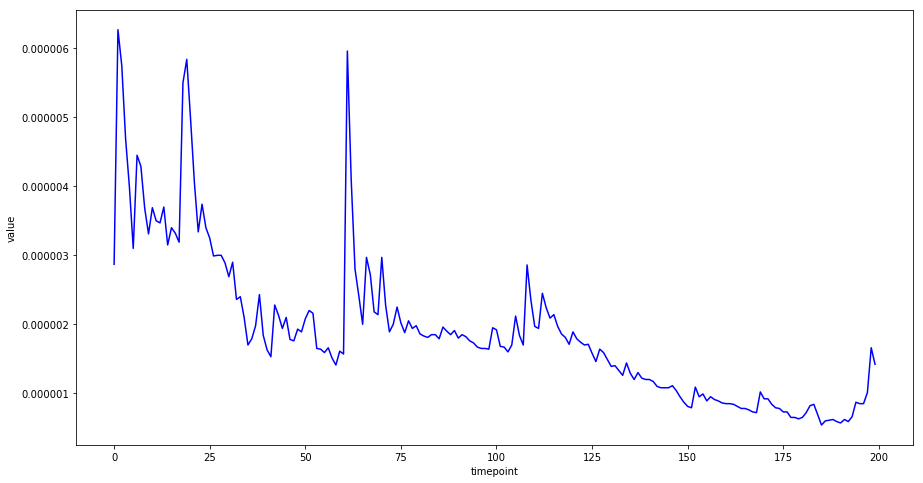

In [8]:
plt.figure(figsize=(15,8))
plt.plot(data[10], color='blue')

plt.xlabel('timepoint')
plt.ylabel('value')

plt.show()

In [12]:
N = 800
T = 200
lags = [1]
L = len(lags)

#### 3. Interpolate missings

In [13]:
data_interpolated = data.copy()

N, T = data_interpolated.shape
total = 0
for i in range(N):
    start = 0
    end = 0
    move = 'start'
    fill = False

    for t in range(T):
        if (move == 'start') and (np.isnan(data_interpolated[i][start])):
            move = 'end'
            end = start
            if start > 0:
                a = data_interpolated[i][start-1]
            else:
                a = 0
        if (move == 'end') and (~np.isnan(data_interpolated[i][end]) or (end == T-1)):
            b = data_interpolated[i][end]
            fill = True
            
        if fill:
            if np.isnan(b):
                b = 0
            for j in range(start, end):
                total += 1
                data_interpolated[i][j] = a + (j-start)*(b-a)/(end-start)
            fill = False
            move = 'start'
            start = end
            
        if move == 'start':
            start += 1
        else:
            end += 1

data_interpolated[np.isnan(data_interpolated)] = 0.

##### 4. Apply models

In [14]:
# Naive model
for h in [1, 5, 10, 20]:
    model = NaiveModel()
    scores_nd = RollingCV(model, data_interpolated, T-9-h, h, T_step=1, metric='ND')
    scores_nrmse = RollingCV(model, data_interpolated, T-9-h, h, T_step=1, metric='NRMSE')
    print('Naive model performance ND/NRMSE (h = {}): {}/{}'.format(h, round(np.array(scores_nd).mean(),3),\
                                                                    round(np.array(scores_nrmse).mean(),3)))

Naive model performance ND/NRMSE (h = 1): 0.158/0.36
Naive model performance ND/NRMSE (h = 5): 0.228/0.574
Naive model performance ND/NRMSE (h = 10): 0.29/0.644
Naive model performance ND/NRMSE (h = 20): 0.347/0.842


In [15]:
# Mean model
for h in [1, 5, 10, 20]:
    model = MeanModel()
    scores_nd = RollingCV(model, data_interpolated, T-9-h, h, T_step=1, metric='ND')
    scores_nrmse = RollingCV(model, data_interpolated, T-9-h, h, T_step=1, metric='NRMSE')
    print('Mean model performance ND/NRMSE (h = {}): {}/{}'.format(h, round(np.array(scores_nd).mean(),3),\
                                                          round(np.array(scores_nrmse).mean(),3)))

Mean model performance ND/NRMSE (h = 1): 1.0/1.293
Mean model performance ND/NRMSE (h = 5): 1.0/1.265
Mean model performance ND/NRMSE (h = 10): 1.0/1.24
Mean model performance ND/NRMSE (h = 20): 1.0/1.322


In [16]:
# AR model
for h in [1, 5, 10, 20]:
    model = AutoRegressionModel(lags)
    scores_nd = RollingCV(model, data_interpolated, T-9-h, h, T_step=1, metric='ND')
    scores_nrmse = RollingCV(model, data_interpolated, T-9-h, h, T_step=1, metric='NRMSE')
    print('AR performance ND/NRMSE (h = {}): {}/{}'.format(h, round(np.array(scores_nd).mean(),3),\
                                                           round(np.array(scores_nrmse).mean(),3)))

AR performance ND/NRMSE (h = 1): 0.168/0.368
AR performance ND/NRMSE (h = 5): 0.258/0.6
AR performance ND/NRMSE (h = 10): 0.369/0.792
AR performance ND/NRMSE (h = 20): 0.528/1.309


In [18]:
# TRMF model
K = 256
lambda_f = 0.001
lambda_x = 0.01
lambda_w = 0.0001
eta = 0.
alpha = 1000.
max_iter = 2000

model = trmf(lags, K, lambda_f, lambda_x, lambda_w, alpha, eta, max_iter)
for h in [1, 5, 10, 20]:
    model = trmf(lags, K, lambda_f, lambda_x, lambda_w, alpha, eta, max_iter)
    scores_nd = RollingCV(model, data, T-9-h, h, T_step=1, metric='ND')
    scores_nrmse = RollingCV(model, data, T-9-h, h, T_step=1, metric='NRMSE')
    print('TRMF performance ND/NRMSE (h = {}): {}/{}'.format(h, round(np.array(scores_nd).mean(),3),\
                                                    round(np.array(scores_nrmse).mean(),3)))

TRMF performance ND/NRMSE (h = 1): 0.233/0.437
TRMF performance ND/NRMSE (h = 5): 0.273/0.619
TRMF performance ND/NRMSE (h = 10): 0.332/0.668
TRMF performance ND/NRMSE (h = 20): 0.429/0.957


### Results Crypto-Currency Data (ND/NRMSE)

| | h=1 | h=5 | h=10 | h=20 ||
|------|------|------|------|
| Naive | **0.158/0.36** | **0.228/0.574** | **0.29/0.644** | **0.347/0.842** |
| Mean | 1.0/1.293 | 1.0/1.265 | 1.0/1.24 | 1.0/1.322 |
| AutoRegression | 0.168/0.368 | 0.258/0.6 | 0.369/0.792 | 0.528/1.309 |
| TRMF | 0.233/0.437 | 0.273/0.619 | 0.332/0.668 | 0.429/0.957 |
